# Northwind Tests

## Table of Contents
### [0. Introduction](#0)
### [1. Discount Effect](#1)
1. [Get Data](#1.1)
2. [Explore and Clean](#1.2)
3. [Experimental Design](#1.3)
  - [Get Samples](#1.3.1)
  - [T Test](#1.3.2)
  - [Analyze Results](#1.3.3)
  - [ANOVA](#1.3.4)
4. [Conclusion](#1.4)
  
### [2. Seasonality](#2)
1. [Hypothesis](#2.1)
2. [Obtain](#2.2)
3. [Data Exploration](#2.3)
4. [Scrubbing](#2.4)
5. [Experiment](#2.5)
6. [Analyze](#2.6)

### [3. Supply Region and Reorder Rates](#3)
1. [Hypothesis](#3.1)
2. [Obtain](#3.2)
3. [Explore and Scrub](#3.3)
4. [Experiment](#3.4)
5. [Analyze](#3.5)

### [4. High Yield Customers](#4)
1. [Hypothesis](#4.1)
2. [Obtain](#4.2)
3. [Explore and Scrub](#4.3)
4. [Experiment](#4.4)
5. [Analyze](#4.5)

### [5. Conclusion](#5)
### [6. Future Work](#6)
### [7. Recap](#7)

<a id="0"></a>
## 0. Introduction
For this project, we'll be working with the Northwind database--a free, open-source dataset created by Microsoft containing data from a fictional company. The goal of this project is to gather information from a real-world database and use our knowledge of statistical analysis and hypothesis testing to generate analytical insights that can be of value to the company.

The goal of your project is to answer the following question:

Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

In addition to answering this question, we will also come up with 3 other hypotheses to test that provide imporant information for the company.

In [540]:
# Imports
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect
import pandas as pd
import numpy as np
import scipy.stats as stats
import random
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Connect to database
engine = create_engine("sqlite:///Northwind_small.sqlite", echo=True)
Session = sessionmaker(bind=engine)
session = Session()

In [541]:
# Use inspect to check database metadata against the ERD we have of the database
inspector = inspect(engine)
table_names = inspector.get_table_names()
print(table_names)

2019-06-10 15:53:56,846 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-06-10 15:53:56,847 INFO sqlalchemy.engine.base.Engine ()
2019-06-10 15:53:56,849 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-06-10 15:53:56,850 INFO sqlalchemy.engine.base.Engine ()
2019-06-10 15:53:56,852 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-06-10 15:53:56,853 INFO sqlalchemy.engine.base.Engine ()
['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


<a id="1"></a>
## 1. Discount Effect
Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

<a id="1.1"></a>
### 1.1 Get Data

Our first step is to query our database for the tables we might need and save the data into a pandas.DataFrames to work with. At this point we will see which of the tables will be necessary for us to gather the data we need to answer our business questions

In [542]:
# I created a couple of functions to make it easier to inspect and retreive necessary data

def get_columns_info(table_name):
    """ Print the name and type of each column in the given table.
    
    Args:
        table_name: Name of the table (string)
    """
    cols_list = inspector.get_columns(table_name)
    
    print("Table Name: {}".format(table_name))
    print("")
    for column in cols_list:
        print("Name: {}, \t {}".format(column['name'], column['type']))


def get_column_names(table_name):
    """ Get the name of each column in the given table.
    
    Args:
        table_name: Name of the table (string)
    
    Returns:
        A list of column names
    """
    cols_list = inspector.get_columns(table_name)
    col_names = []
    for column in cols_list:
        col_names.append(column['name'])
    return col_names

get_columns_info('Employee')

2019-06-10 15:53:56,917 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Employee")
2019-06-10 15:53:56,919 INFO sqlalchemy.engine.base.Engine ()
Table Name: Employee

Name: Id, 	 INTEGER
Name: LastName, 	 VARCHAR(8000)
Name: FirstName, 	 VARCHAR(8000)
Name: Title, 	 VARCHAR(8000)
Name: TitleOfCourtesy, 	 VARCHAR(8000)
Name: BirthDate, 	 VARCHAR(8000)
Name: HireDate, 	 VARCHAR(8000)
Name: Address, 	 VARCHAR(8000)
Name: City, 	 VARCHAR(8000)
Name: Region, 	 VARCHAR(8000)
Name: PostalCode, 	 VARCHAR(8000)
Name: Country, 	 VARCHAR(8000)
Name: HomePhone, 	 VARCHAR(8000)
Name: Extension, 	 VARCHAR(8000)
Name: Photo, 	 BLOB
Name: Notes, 	 VARCHAR(8000)
Name: ReportsTo, 	 INTEGER
Name: PhotoPath, 	 VARCHAR(8000)


In [543]:
con = engine.connect()

<a id="1.2"></a>
### 1.2 Explore and Clean

In [544]:
def get_table_data(table_name, con=con):
    """Get the data from the given table
    
    Args:
        con: Database connection
        table_name: Name of the table (string)
    
    Returns:
        Pandas Dataframe with the data from the table
    """
    table = con.execute("SELECT * FROM '{}'".format(table_name))
    table_df = pd.DataFrame(table.fetchall())
    col = get_column_names('{}'.format(table_name))
    table_df.columns = col
    return table_df


products_df = get_table_data('Product')
details_df = get_table_data('OrderDetail')
orders_df = get_table_data('Order')

products_df.head()

2019-06-10 15:53:56,976 INFO sqlalchemy.engine.base.Engine SELECT * FROM 'Product'
2019-06-10 15:53:56,977 INFO sqlalchemy.engine.base.Engine ()
2019-06-10 15:53:56,981 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Product")
2019-06-10 15:53:56,982 INFO sqlalchemy.engine.base.Engine ()
2019-06-10 15:53:56,983 INFO sqlalchemy.engine.base.Engine SELECT * FROM 'OrderDetail'
2019-06-10 15:53:56,984 INFO sqlalchemy.engine.base.Engine ()
2019-06-10 15:53:56,993 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("OrderDetail")
2019-06-10 15:53:56,994 INFO sqlalchemy.engine.base.Engine ()
2019-06-10 15:53:56,996 INFO sqlalchemy.engine.base.Engine SELECT * FROM 'Order'
2019-06-10 15:53:56,997 INFO sqlalchemy.engine.base.Engine ()
2019-06-10 15:53:57,005 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Order")
2019-06-10 15:53:57,007 INFO sqlalchemy.engine.base.Engine ()


,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


In [545]:
print(details_df.loc[details_df['OrderId'] == 10249])
print(details_df.loc[details_df['ProductId'] == 5])

         Id  OrderId  ProductId  UnitPrice  Quantity  Discount
3  10249/14    10249         14       18.6         9       0.0
4  10249/51    10249         51       42.4        40       0.0
           Id  OrderId  ProductId  UnitPrice  Quantity  Discount
30    10258/5    10258          5      17.00        65      0.20
40    10262/5    10262          5      17.00        12      0.20
111   10290/5    10290          5      17.00        20      0.00
352   10382/5    10382          5      17.00        32      0.00
1022  10635/5    10635          5      21.35        15      0.10
1212  10708/5    10708          5      21.35         4      0.00
1575  10848/5    10848          5      21.35        30      0.00
1840  10958/5    10958          5      21.35        20      0.00
2018  11030/5    11030          5      21.35        70      0.00
2061  11047/5    11047          5      21.35        30      0.25


Filtering details_df by OrderId shows that each record in the `OrderDetail` table describes one product within one order. So, each observation in `Order` table will have one or more observations in the `OrderDetail` table. This means we don't need the `Orders` table as it mainly describes details about the shippment and not what's in the order. 

When looking at all the observations of the same product in the `OrderDetail` table shows that the company didn't always use the price listed in the `Product` table's `UnitPrice`. The quantities and discount levels don't seem to be causing the difference and it's not the average price. So we'll assume the `Product` table's `UnitPrice` to be the suggested price and therefore isn't relevant for what we're trying to acomplish.

This just leaves us with the `OrderDetail` table. We'll drop the columns we won't need to clean up the DataFrame.

In [546]:
df = details_df.drop(['Id'], axis=1)
df.head()

,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248,11,14.0,12,0.0
1,10248,42,9.8,10,0.0
2,10248,72,34.8,5,0.0
3,10249,14,18.6,9,0.0
4,10249,51,42.4,40,0.0


In [547]:
df['ProductId'].value_counts()
df['Discount'].value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

**Scrub Data**

Looking at the values we have in each column, there are some discount values that don't have enough observations to make any statistical inferences. We'll drop all rows that contain the following values:
- 0.01
- 0.02
- 0.03
- 0.04
- 0.06

In [548]:
drop_list = [0.01, 0.02, 0.03, 0.04, 0.06]
df = df[~df['Discount'].isin(drop_list) ]
df['Discount'].value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
Name: Discount, dtype: int64

<a id="1.3"></a>
### 1.3 Experimental Design

<a id="1.3.1"></a>
#### Get Samples

In [549]:
treatment = df.loc[df['Discount'] != 0]
control = df.loc[df['Discount'] == 0]
treatment['Discount'].value_counts()
treatment.head()

,OrderId,ProductId,UnitPrice,Quantity,Discount
6,10250,51,42.4,35,0.15
7,10250,65,16.8,15,0.15
8,10251,22,16.8,6,0.05
9,10251,57,15.6,15,0.05
11,10252,20,64.8,40,0.05


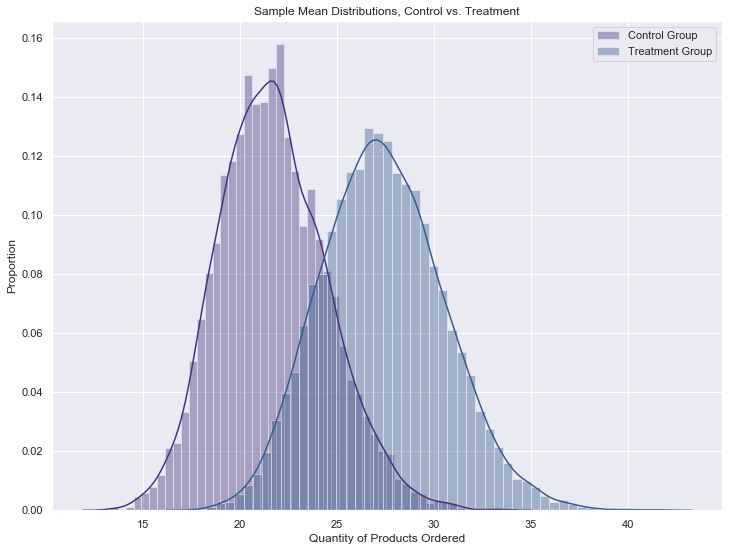

In [680]:
def get_pop_mean(group, size=10000):
    """Get the population mean by using the central limit theorem
    
    Args:
        group: (pd.Series) observations, must be numerical
        size: (int) size of distribution
    
    Returns:
        float: population mean
    """
    xbars = []
    for i in range(size):
        xbars.append(np.mean(group.sample(n=40)))
    return xbars

control_quantity_dist = get_pop_mean(control.Quantity)
treatment_quantity_dist = get_pop_mean(treatment.Quantity)

plt.figure(figsize=(12,9))
sns.distplot(control_quantity_dist, label='Control Group')
sns.distplot(treatment_quantity_dist, label='Treatment Group')
plt.legend()
plt.title('Sample Mean Distributions, Control vs. Treatment')
plt.xlabel('Quantity of Products Ordered')
plt.ylabel('Proportion')
plt.savefig('discount_rate_1.png')

Visually inspecting the population mean distributions, the discounted group looks different from the control group but there is a fair amount of overlap between the two.

<a id="1.3.2"></a>
#### T Test

To make sure our two groups have a statistically significant difference, we'll run a t-test using the stats library.

*Form Hypothesis*

Now that we have our treament and control datasets, we can execute our hypothesis test.

>$H_o: \mu_t = \mu_c$

>$H_a: \mu_t > \mu_c$

>
$\alpha$ = 0.05

*Conduct Experiment*

We'll take a sample from our control and treatment groups and run a one-sided, two-sample hypothesis test with an alpha level of 0.05.

In [551]:
sample_t = pd.DataFrame(treatment_quantity_dist).sample(n = 50, random_state=10)
sample_c = pd.DataFrame(control_quantity_dist).sample(n = 50, random_state=10)
results = stats.ttest_rel(sample_t, sample_c)
alpha = 0.05
if (results[0] > 0) & (results[1]/2 < alpha):
    print("reject null hypothesis, mean of {} is greater than mean of {}".format('Discounted Quantities','Nondiscounted Quantities'))
else:
    print("fail to reject null hypothesis")

reject null hypothesis, mean of Discounted Quantities is greater than mean of Nondiscounted Quantities


<a id="1.3.3"></a>
#### Analyze Results
We have significant evidence to reject the null hypothsis that the mean quanitites of discount orders is equal to the mean quantities on nondiscounted orders. 

<a id="1.3.4"></a>
#### ANOVA
*Determine if the level of discount effects quantities purchased*

Now that we have accepted that discounts do increase the quantity of items purchased, we need to figure out at what discount level is the effect most significant. We'll start with an ANOVA test to figure out if there is a difference in effect between the different levels of discounts.


*Form Hypothesis*
>$H_o: \mu_{0.05} = \mu_{0.10} = \mu_{0.15} = \mu_{0.20} = \mu_{0.25}$ 

>$H_a: \mu_{0.05} != \mu_{0.10} != \mu_{0.15} != \mu_{0.20} != \mu_{0.25}$ 

*Sample Different Discount Rates*



In [552]:
five = treatment.loc[treatment['Discount'] == 0.05]
ten = treatment.loc[treatment['Discount'] == 0.10]
fifteen = treatment.loc[treatment['Discount'] == 0.15]
twenty = treatment.loc[treatment['Discount'] == 0.20]
twentyfive = treatment.loc[treatment['Discount'] == 0.25]

data = pd.DataFrame()

for group, name in [(five, '0.05'), (ten, '0.10'), (fifteen, '0.15'), (twenty, '0.20'), (twentyfive, '0.25')]:
    group = group.sample(n=50, random_state=10)
    data[name] = group.Quantity.reset_index(drop=True)
data.head()

,0.05,0.10,0.15,0.20,0.25
0,12,20,24,40,20
1,28,18,70,55,2
2,24,18,40,6,12
3,8,15,10,30,20
4,2,10,16,45,30


/Users/joe/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


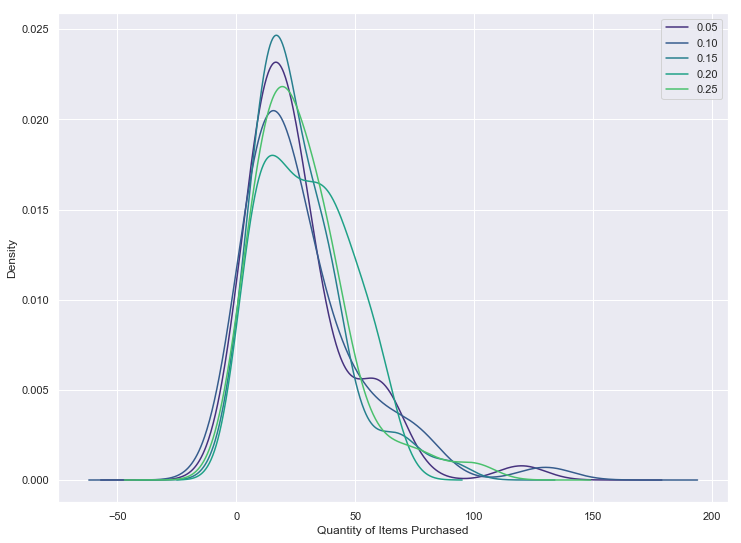

In [681]:
fig, ax = plt.subplots(1, 1, figsize=(12,9))
for i in data.columns:
    data[i].plot(kind='density')
plt.legend()
plt.xlabel('Quantity of Items Purchased')
fig.show()
plt.savefig('discount_rate_2.png')

In [554]:
# One-way ANOVA test
stats.f_oneway(data['0.05'], data['0.10'], data['0.15'], data['0.20'], data['0.25'])

F_onewayResult(statistic=0.22583337048873584, pvalue=0.92379289841810175)

*Analyze Results*

Our F-statistic of 0.2258 suggests the between-groups variance is roughly 1/4 of the within-group variance. We fail to reject the null hypothesis of equal mean values  due to the p value being > 0.05. 

<a id="1.4"></a>
### 1.4 Conclusion

These results aren't surprising considering the density plots of our samples. They are visually close to identical so our recommendation is to stick with low levels of discounts as there is no evidence to say that increasing the discount level will increase the quantity bought, so it just reduces the revenue earned.

<a id="2"></a>
## 2. Is the business seasonal?
Next we'll look at the seasonality of the business. We want to see if there is a time of year that where sales are significantly higher. This will give us more insight when we're forecasting sales and planning marketing campaigns. 

<a id="2.1"></a>
### 2.1 Hypothesis
>$H_o: \mu_0 = \mu_1, \mu_x$

>$H_o: \mu_0 > \mu_1, \mu_x$

<a id="2.2"></a>
### 2.2 Obtain

In [688]:
# Get data
table = con.execute("""SELECT Id, OrderDate FROM 'Order';""")
orders = pd.DataFrame(table.fetchall())
orders.columns = ['Id', 'OrderDate']
details = get_table_data('OrderDetail')

# Drop unwanted columns
details = details.drop(['Id'], axis=1)

# Data Manipulation
orders['OrderDate'] = pd.to_datetime(orders['OrderDate'])
orders['Year'] = orders['OrderDate'].dt.year
orders['Month'] = orders['OrderDate'].dt.month

# Calculate revenue based on Unit Price, Quantity and Discount
details['Revenue'] = details['UnitPrice'] * details['Quantity'] * (1 - details['Discount'])
details = details.drop(['UnitPrice', 'Quantity', 'Discount'], axis=1)

2019-06-14 14:04:18,605 INFO sqlalchemy.engine.base.Engine SELECT Id, OrderDate FROM 'Order';
2019-06-14 14:04:18,607 INFO sqlalchemy.engine.base.Engine ()
2019-06-14 14:04:18,611 INFO sqlalchemy.engine.base.Engine SELECT * FROM 'OrderDetail'
2019-06-14 14:04:18,612 INFO sqlalchemy.engine.base.Engine ()


<a id="2.3"></a>
### 2.3 Data Exploration

Now we have all the data we need to run an expirment. We'll need to merge the DataFrames but first we'll look at a bar graph to see if there is any visual evidence to our claim.

Text(0.5, 1.0, 'Number of Orders by Month')

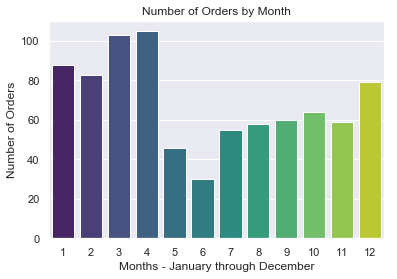

In [689]:
orders_by_month = pd.DataFrame(orders.Month.value_counts())
orders_by_month.sort_index(inplace=True)

sns.barplot(x=orders_by_month.index, y=orders_by_month['Month'], palette='viridis')
plt.xlabel('Months - January through December')
plt.ylabel('Number of Orders')
plt.title('Number of Orders by Month')

There does seem to be seasonality to the number of orders placed but that doesn't necessarily mean that revenues are higher in any given period. Our next step is to join our DataFrames so we can access all the data we need in one DataFrame.

In [690]:
details['Id'] = details['OrderId']
details.drop(['OrderId'], axis=1, inplace=True)
result = pd.merge(orders, details, how='inner', on='Id')
result.head()

,Id,OrderDate,Year,Month,ProductId,Revenue
0,10248,2012-07-04,2012,7,11,168.0
1,10248,2012-07-04,2012,7,42,98.0
2,10248,2012-07-04,2012,7,72,174.0
3,10249,2012-07-05,2012,7,14,167.4
4,10249,2012-07-05,2012,7,51,1696.0


Text(0.5, 1.0, 'Revenue by Month')

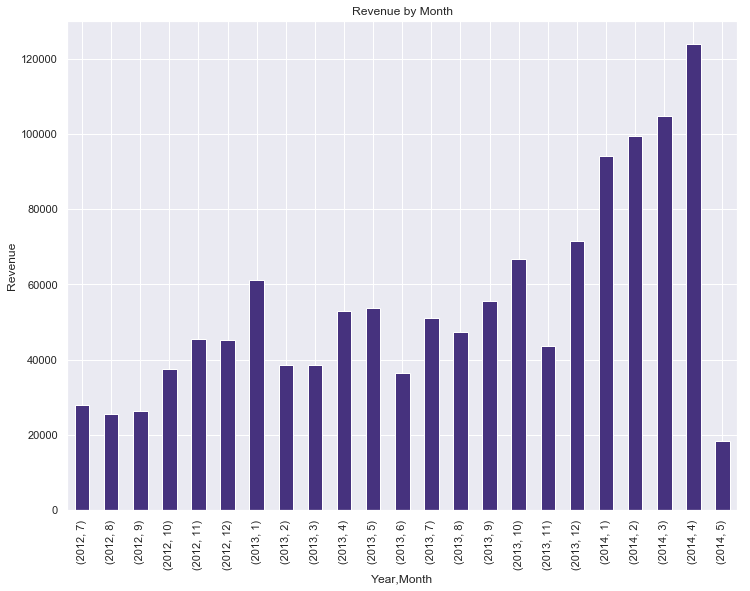

In [691]:
plt.figure(figsize=(12,9))
result.groupby(['Year', 'Month'])['Revenue'].sum().plot(kind='bar')
plt.ylabel('Revenue')
plt.title('Revenue by Month')

Looking at the results of revenue per month, we see there is a general trend of revenue growth. To make sure we aren't just capturing this overal growth, we'll calculate a regression line for the growth month over month and run ANOVA to analyze the variance between the projected revenue and the actual revenue.

Additionally, May 2014 seems unusually low. I'll check to make sure that the whole month's sales were included and that the tracking didn't get cut off mid month.

<a id="2.4"></a>
### 2.4 Scrubbing

In [692]:
result.loc[(result['Year'] == 2014) & (result['Month'] == 5)]['OrderDate'].value_counts()

2014-05-06    32
2014-05-05    12
2014-05-01    10
2014-05-04     5
Name: OrderDate, dtype: int64

There are only four days in which orders were placed with the last day being the 6th of the month. Most likely they stopped collecting data on that day, so we don't have the whole month's data to work with. We'll drop any observations that was in that month.

In [693]:
unwanted_rows = result[(result['Year'] == 2014) & (result['Month'] == 5)]
df = pd.concat([result, unwanted_rows])
df.drop_duplicates(keep=False, inplace=True)
unwanted_rows.OrderDate.value_counts()

df.loc[(df['Year'] == 2014) & (df['Month'] == 5)]['OrderDate'].value_counts()


Series([], Name: OrderDate, dtype: int64)

We create a `Season` column by mapping a season to each of those months.

In [694]:
# add a season column to later sort by
seasons = {1: 'Winter',
          2: 'Winter',
          3: 'Spring',
          4: 'Spring',
          5: 'Spring',
          6: 'Summer',
          7: 'Summer',
          8: 'Summer',
          9: 'Fall',
          10: 'Fall',
          11: 'Fall',
          12: 'Winter'}
df['Season'] = df['Month'].map(seasons)
pd.DataFrame(df.groupby(['Year', 'Season'])['Revenue'].sum())


Revenue
Year Season             
2012 Fall    109497.1700
     Summer   53347.1700
     Winter   45239.6300
2013 Fall    165912.2775
     Spring  145361.4625
     Summer  134671.3300
     Winter  171140.1335
2014 Spring  228652.8375
     Winter  193637.3980

Because our data covers such a short period of time, we have some misleading figures when we `GROUPBY` year and season. For example, the winter of 2012 only includes one month of sales, so it's artificially lower. To account for the general growth and the misleading figures, we'll build a regression model to compare each individual month's figures to come up with a statistic to show how each month performed compared to expectations. Once we have our new `Variance` Column, we can group each observation into seasons. From there we can run an ANOVA test to determine if there is a stastical difference between seasons in terms of revenue accounted for growth. 

In [709]:
# group Revenue by Year and Month
revenue = pd.DataFrame(df.groupby(['Year', 'Month'])['Revenue'].sum())
# add a numeric index for regression
revenue.reset_index(inplace=True)

# regression model
from sklearn.linear_model import LinearRegression

from statsmodels.api import OLS
reg = OLS(revenue['Revenue'].reshape(-1, 1),np.array(revenue.index).reshape(-1, 1)).fit()

reg.summary()

/Users/joe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     236.4
Date:                Fri, 14 Jun 2019   Prob (F-statistic):           6.66e-13
Time:                        14:12:42   Log-Likelihood:                -246.58
No. Observations:                  22   AIC:                             495.2
Df Residuals:                      21   BIC:                             496.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          4880.3689    317.391     15.377      0.000    4220.318    5540.420
==============================================================================
Omnibus:                        0.940   Durbin-Watson:                   0.531
Prob(Omnibus):                  0.625   Jarque-Bera (JB):                0.896
Skew:                          -0.413   Prob(JB):                        0.639
Kurtosis:                       2.456   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now that we have our regression line and it is highly predictive of the data ($r^2$:  0.918), we'll use that to calculate the variance. Then we'll group the variances of each individual month into season and use that dataset to run our ANOVA test.

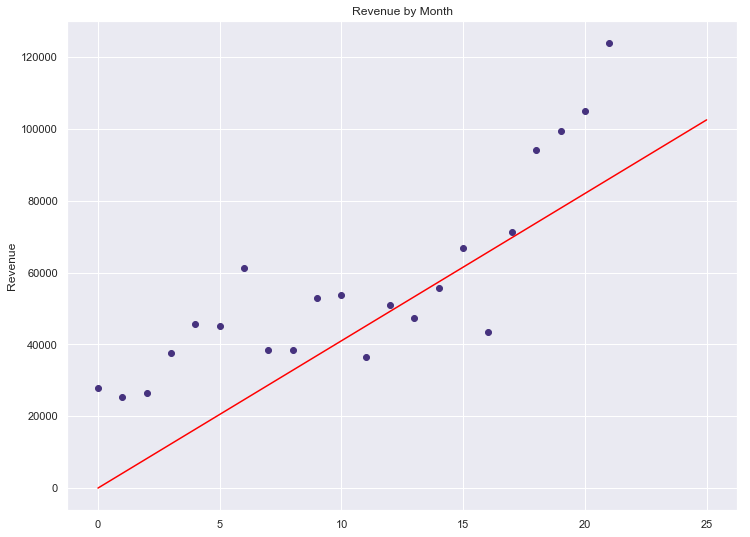

In [710]:
import statsmodels.api as sm
plt.figure(figsize=(12,9))
# result.groupby(['Year', 'Month'])['Revenue'].sum().plot(kind='bar')

plt.scatter(np.array(revenue.index), revenue['Revenue'], label='Actual')
plt.plot(np.linspace(0,25,22), reg.predict(revenue.index), label='Growth Prediction', color='red')
plt.ylabel('Revenue')
plt.title('Revenue by Month')
plt.savefig('seasonality1.png')

In [627]:
revenue['Season'] = revenue['Month'].map(seasons)
revenue['Variance'] = revenue['Revenue'] - reg.predict(revenue.index)
revenue.head()

,Year,Month,Revenue,Season,Variance
0,2012,7,27861.895,Summer,27861.895000
1,2012,8,25485.275,Summer,20604.906108
2,2012,9,26381.400,Fall,16620.662215
3,2012,10,37515.725,Fall,22874.618323
4,2012,11,45600.045,Fall,26078.569431


In [628]:
spring = []
summer = []
fall = []
winter = []
for index, row in revenue.iterrows():
    if row['Season'] == 'Spring':
        spring.append(row['Variance'])
    elif row['Season'] == 'Summer':
        summer.append(row['Variance'])
    elif row['Season'] == 'Fall':
        fall.append(row['Variance'])
    elif row['Season'] == 'Winter':
        winter.append(row['Variance'])

spring = pd.DataFrame(data=spring, columns=['Spring'])
summer = pd.DataFrame(data=summer, columns=['Summer'])
fall = pd.DataFrame(data=fall, columns=['Fall'])
winter = pd.DataFrame(data=winter, columns=['Winter'])



<a id="2.5"></a>
### 2.5 Experiment

In [629]:
# One-way ANOVA test
stats.f_oneway(spring, summer, fall, winter)

F_onewayResult(statistic=array([ 0.3051157]), pvalue=array([ 0.8213299]))

<a id="2.6"></a>
### 2.6 Analyze

With an F-statistic of `0.3051`, we know that most of the variation in the dataset is within the seasons and not between them. A large p-value of `0.8213` indicates that there isn't enough statistical proof to indicate that the there is a difference in revenue between the seasons. 

<a id="3"></a>
## 3. Which supply region has a lower reoder level for products?
<a id="3.1"></a>
### 3.1 Hypothesis
>$H_o: \mu_0 = \mu_1 ... = \mu_x$

>$H_a: \mu_0 != \mu_1 ... !=\mu_x$

<a id="3.2"></a>
### 3.2 Obtain
The data we need is in the `Supplier` and `Product` tables

In [717]:
# Import supplier data
supplier_df = get_table_data('Supplier')
supplier_df = con.execute("SELECT id, CompanyName, Region FROM 'Supplier';")
supplier_df = pd.DataFrame(supplier_df.fetchall())
supplier_df.columns = ['Id', 'SupplierName', 'Region']

# import product data and removed discontinued products
product_df = con.execute("SELECT Id, ProductName, SupplierId, ReorderLevel, Discontinued FROM 'Product';")
product_df = pd.DataFrame(product_df.fetchall())
product_df.columns = ['Id', 'ProductName', 'SupplierId', 'ReorderLevel', 'Discontinued']
product_df = product_df.loc[product_df['Discontinued'] == 0]

# Drop unneeded columns
product_df.drop(['Discontinued'], axis=1, inplace=True)

# Merge and cleanup DataFrames
df = supplier_df.merge(product_df, left_on='Id', right_on='SupplierId', how='left',suffixes=('', '_p'))
df.drop(['SupplierId'], axis=1, inplace=True)
df.rename(columns={'Id': 'SupplierId', 'Id_p': 'ProductId'}, inplace=True)
df.head()

2019-06-14 14:18:12,559 INFO sqlalchemy.engine.base.Engine SELECT * FROM 'Supplier'
2019-06-14 14:18:12,560 INFO sqlalchemy.engine.base.Engine ()
2019-06-14 14:18:12,564 INFO sqlalchemy.engine.base.Engine SELECT id, CompanyName, Region FROM 'Supplier';
2019-06-14 14:18:12,565 INFO sqlalchemy.engine.base.Engine ()
2019-06-14 14:18:12,568 INFO sqlalchemy.engine.base.Engine SELECT Id, ProductName, SupplierId, ReorderLevel, Discontinued FROM 'Product';
2019-06-14 14:18:12,569 INFO sqlalchemy.engine.base.Engine ()


,SupplierId,SupplierName,Region,ProductId,ProductName,ReorderLevel
0,1,Exotic Liquids,British Isles,1.0,Chai,10.0
1,1,Exotic Liquids,British Isles,2.0,Chang,25.0
2,1,Exotic Liquids,British Isles,3.0,Aniseed Syrup,25.0
3,2,New Orleans Cajun Delights,North America,4.0,Chef Anton's Cajun Seasoning,0.0
4,2,New Orleans Cajun Delights,North America,65.0,Louisiana Fiery Hot Pepper Sauce,0.0


In [718]:
df.groupby(['Region'])['ProductId'].count()


Region
British Isles       7
Eastern Asia        5
NSW                 2
North America      15
Northern Europe     9
Scandinavia         6
South America       0
South-East Asia     2
Southern Europe     7
Victoria            4
Western Europe     12
Name: ProductId, dtype: int64

In [719]:
british_isles = df.loc[df['Region'] == 'British Isles']
eastern_asia = df.loc[df['Region'] == 'Eastern Asia']
nsw = df.loc[df['Region'] == 'NSW']
north_america = df.loc[df['Region'] == 'North America']
northern_europe = df.loc[df['Region'] == 'Northern Europe']
scandinavia = df.loc[df['Region'] == 'Scandinavia']
south_east_asia = df.loc[df['Region'] == 'South-East Asia']
southern_europe = df.loc[df['Region'] == 'Southern Europe']
victoria = df.loc[df['Region'] == 'Victoria']
western_europe = df.loc[df['Region'] == 'Western Europe']
results = pd.DataFrame(df.groupby(['Region'])['ReorderLevel'].mean())
results

,ReorderLevel
Region,
British Isles,12.142857
Eastern Asia,3.000000
NSW,17.500000
North America,12.666667
Northern Europe,15.555556
Scandinavia,16.666667
South America,NaN
South-East Asia,20.000000
Southern Europe,17.857143


<a id="3.3"></a>
### 3.3 Explore and Scrub

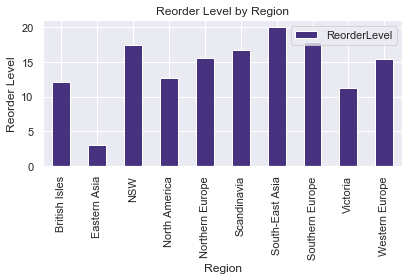

In [720]:
results.drop(['South America'], inplace=True)

results.plot(kind='bar')
plt.title('Reorder Level by Region')
plt.xlabel('Region')
plt.ylabel('Reorder Level')
plt.tight_layout()
plt.savefig('reorder_levels.png')

In [645]:
british_isles = df.loc[df['Region'] == 'British Isles']
eastern_asia = df.loc[df['Region'] == 'Eastern Asia']
nsw = df.loc[df['Region'] == 'NSW']
north_america = df.loc[df['Region'] == 'North America']
northern_europe = df.loc[df['Region'] == 'Northern Europe']
scandinavia = df.loc[df['Region'] == 'Scandinavia']
south_east_asia = df.loc[df['Region'] == 'South-East Asia']
southern_europe = df.loc[df['Region'] == 'Southern Europe']
victoria = df.loc[df['Region'] == 'Victoria']
western_europe = df.loc[df['Region'] == 'Western Europe']

region_dfs = [british_isles, eastern_asia, nsw, north_america, northern_europe, scandinavia,
             south_east_asia, southern_europe, victoria, western_europe]

In [646]:
southern_europe.head()

,SupplierId,SupplierName,Region,ProductId,ProductName,ReorderLevel
11,5,Cooperativa de Quesos 'Las Cabras',Southern Europe,11.0,Queso Cabrales,30.0
12,5,Cooperativa de Quesos 'Las Cabras',Southern Europe,12.0,Queso Manchego La Pastora,0.0
34,14,Formaggi Fortini s.r.l.,Southern Europe,31.0,Gorgonzola Telino,20.0
35,14,Formaggi Fortini s.r.l.,Southern Europe,32.0,Mascarpone Fabioli,25.0
36,14,Formaggi Fortini s.r.l.,Southern Europe,72.0,Mozzarella di Giovanni,0.0


<a id="3.4"></a>
### 3.4 Experiment
We'll run a one sample t-test for each region. 

British Isles
Ttest_1sampResult(statistic=-0.47116020365080752, pvalue=0.65416929529214585)
----------------
Eastern Asia
Ttest_1sampResult(statistic=-8.9104626875156185, pvalue=0.00087687200506487701)
***Region's reorder level is lower than other regions***
***Statistically significant***
----------------
NSW
Ttest_1sampResult(statistic=0.47826086956521746, pvalue=0.71600038697973556)
----------------
North America
Ttest_1sampResult(statistic=-0.48387311708827668, pvalue=0.63595707862010165)
----------------
Northern Europe
Ttest_1sampResult(statistic=0.44698407242830357, pvalue=0.66673996077089526)
----------------
Scandinavia
Ttest_1sampResult(statistic=0.68602787705263502, pvalue=0.523205137218683)
----------------
South-East Asia
Ttest_1sampResult(statistic=1.2173913043478262, pvalue=0.43778511848310447)
----------------
Southern Europe
Ttest_1sampResult(statistic=0.8112021857354057, pvalue=0.44822470632661959)
----------------
Victoria
Ttest_1sampResult(statistic=-0.4050324557699

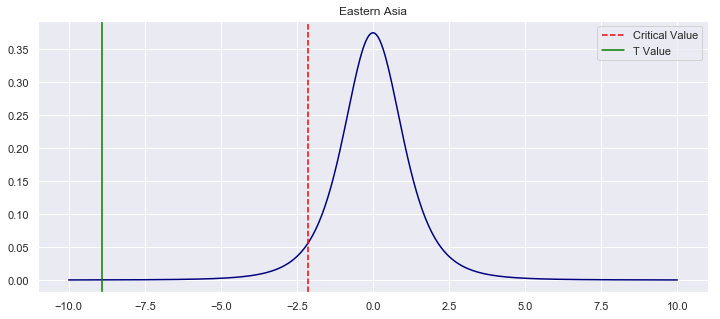

In [647]:
super_mean = np.mean(df['ReorderLevel'])
for region in region_dfs:
    print(region['Region'].iloc[0])
#     print(row['ReorderLevel'])
    output = stats.ttest_1samp(region['ReorderLevel'], super_mean)
    print(output)
    critical = stats.t.ppf(1-alpha, (len(region)-1))
    if output[0] < (-1 * critical):
        print('***Region\'s reorder level is lower than other regions***')
        if output[1] < alpha:
            print('***Statistically significant***')
        # generate points on the x axis between -5 and 5:
        xs = np.linspace(-10, 10, 400)
        # use stats.t.pdf to get values on the probability density function for the t-distribution
        # the second argument is the degrees of freedom
        ys = stats.t.pdf(xs, (len(region)-1), 0, 1)
        # initialize a matplotlib "figure"
        fig = plt.figure(figsize=(12, 5))
        # get the current "axis" out of the figure
        ax = fig.gca()
        # plot the lines using matplotlib's plot function:
        plt.plot(xs, ys, color='navy')
        # plot a vertical line for our measured difference in rates t-statistic
        plt.axvline((-1 * critical), color='red', linestyle='--', label='Critical Value')
        plt.axvline(output[0], color='green', label='T Value')
        plt.legend()
        plt.title(region['Region'].iloc[0])
    print('----------------')

<a id="3.5"></a>
### 3.5 Analyze

As we expected, Eastern Asia has a significantly lower reorder level than other regions. We are able to reject the null hypothesis and accept the alternative hypothesis that Eastern Asia is different from other regions in terms of reorder level. No other regions had a statistically significant difference. In future work, we'll want to look into what makes Eastern Asia so different. Are they able to deliver items faster? Do their products sell infrequently enough not to effect the bottom line? Or is there opportunity to generate more revenues if we reorder their product earlier?

<a id="4"></a>
## 4 What customers generate the most revenue?
We want to determine which customers generate a higher portion of revenue than expected so we can focus our efforts more on customers that make us the most money. If they choose to use another supplier, it would have a much more profound effect on our bottom line than an average customer. 

<a id="4.1"></a>
### 4.1 Hypothesis
>$H_o: \mu_0 = \mu_1, \mu_x$

>$H_o: \mu_0 > \mu_1, \mu_x$

<a id="4.2"></a>
### 4.2 Obtain
The data that we need is spread over three database tables, `Customer`, `Order`, `OrderDetail`.

In [721]:
customer = get_table_data('Customer')
customer.drop(['ContactName', 'ContactTitle', 'Address', 'City', 'Region', 'PostalCode', 'Country', 'Phone', 'Fax'], axis=1, inplace=True)
customer = con.execute("SELECT Id, CompanyName FROM 'Customer';")
customer = pd.DataFrame(customer.fetchall())
customer.columns = ['Id', 'CompanyName']

orders = con.execute("SELECT Id, CustomerId FROM 'Order';")
orders = pd.DataFrame(orders.fetchall())
orders.columns = ['Id', 'CustomerId']

details = con.execute("SELECT OrderId, ProductId, UnitPrice, Quantity, Discount FROM 'OrderDetail';")
details = pd.DataFrame(details.fetchall())
details.columns = ['OrderId', 'ProductId', 'UnitPrice', 'Quantity', 'Discount']

customer.head(1)

2019-06-14 14:21:36,345 INFO sqlalchemy.engine.base.Engine SELECT * FROM 'Customer'
2019-06-14 14:21:36,347 INFO sqlalchemy.engine.base.Engine ()
2019-06-14 14:21:36,351 INFO sqlalchemy.engine.base.Engine SELECT Id, CompanyName FROM 'Customer';
2019-06-14 14:21:36,352 INFO sqlalchemy.engine.base.Engine ()
2019-06-14 14:21:36,355 INFO sqlalchemy.engine.base.Engine SELECT Id, CustomerId FROM 'Order';
2019-06-14 14:21:36,356 INFO sqlalchemy.engine.base.Engine ()
2019-06-14 14:21:36,360 INFO sqlalchemy.engine.base.Engine SELECT OrderId, ProductId, UnitPrice, Quantity, Discount FROM 'OrderDetail';
2019-06-14 14:21:36,361 INFO sqlalchemy.engine.base.Engine ()


,Id,CompanyName
0,ALFKI,Alfreds Futterkiste


In [722]:
orders.head(1)

,Id,CustomerId
0,10248,VINET


In [723]:
details.head(1)

,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248,11,14.0,12,0.0


In [724]:
df = customer.merge(orders, left_on='Id', right_on='CustomerId', how='left',suffixes=('_c', '_o'))
df = df.merge(details, left_on='Id_o', right_on='OrderId', how='left',suffixes=('', '_o'))
df.drop(['Id_c', 'Id_o'], axis=1, inplace=True)
df.head()

,CompanyName,CustomerId,OrderId,ProductId,UnitPrice,Quantity,Discount
0,Alfreds Futterkiste,ALFKI,10643.0,28.0,45.6,15.0,0.25
1,Alfreds Futterkiste,ALFKI,10643.0,39.0,18.0,21.0,0.25
2,Alfreds Futterkiste,ALFKI,10643.0,46.0,12.0,2.0,0.25
3,Alfreds Futterkiste,ALFKI,10692.0,63.0,43.9,20.0,0.00
4,Alfreds Futterkiste,ALFKI,10702.0,3.0,10.0,6.0,0.00


In [725]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2084 entries, 0 to 2083
Data columns (total 7 columns):
CompanyName    2084 non-null object
CustomerId     2078 non-null object
OrderId        2078 non-null float64
ProductId      2078 non-null float64
UnitPrice      2078 non-null float64
Quantity       2078 non-null float64
Discount       2078 non-null float64
dtypes: float64(5), object(2)
memory usage: 130.2+ KB


<a id="4.3"></a>
### 4.3 Scrub
We'll need to remove any observations with null values. There are, relatively, very few of them, leaving them out of our analysis won't effect the results much if any. 

In [726]:
df.isnull().sum()

CompanyName    0
CustomerId     6
OrderId        6
ProductId      6
UnitPrice      6
Quantity       6
Discount       6
dtype: int64

In [727]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2078 entries, 0 to 2083
Data columns (total 7 columns):
CompanyName    2078 non-null object
CustomerId     2078 non-null object
OrderId        2078 non-null float64
ProductId      2078 non-null float64
UnitPrice      2078 non-null float64
Quantity       2078 non-null float64
Discount       2078 non-null float64
dtypes: float64(5), object(2)
memory usage: 129.9+ KB


Next, we will need to calculate the revenue for each order. That is the statistic we want to look at and our database doesn't directly store that information. We'll have to use the following formula:
>Revenue = Unit Price \* Quantity \* (1 - Discount)

In [728]:
df['Revenue'] = df['UnitPrice'] * df['Quantity'] * (1 - df['Discount'])
df.head()

,CompanyName,CustomerId,OrderId,ProductId,UnitPrice,Quantity,Discount,Revenue
0,Alfreds Futterkiste,ALFKI,10643.0,28.0,45.6,15.0,0.25,513.0
1,Alfreds Futterkiste,ALFKI,10643.0,39.0,18.0,21.0,0.25,283.5
2,Alfreds Futterkiste,ALFKI,10643.0,46.0,12.0,2.0,0.25,18.0
3,Alfreds Futterkiste,ALFKI,10692.0,63.0,43.9,20.0,0.00,878.0
4,Alfreds Futterkiste,ALFKI,10702.0,3.0,10.0,6.0,0.00,60.0


In [729]:
rev_by_orders = pd.DataFrame(df.groupby(['OrderId'])['CompanyName', 'Revenue'].sum())

rev_by_orders.reset_index(inplace=True)
rev_by_orders.info()
# rev_by_orders.index

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 2 columns):
OrderId    801 non-null float64
Revenue    801 non-null float64
dtypes: float64(2)
memory usage: 12.6 KB


In [730]:
company_info = df.iloc[:,:3]
company_info.head()
df = rev_by_orders.merge(company_info,left_on='OrderId', right_on='OrderId', how='left')
df.head()

,OrderId,Revenue,CompanyName,CustomerId
0,10248.0,440.0,Vins et alcools Chevalier,VINET
1,10248.0,440.0,Vins et alcools Chevalier,VINET
2,10248.0,440.0,Vins et alcools Chevalier,VINET
3,10249.0,1863.4,Toms Spezialitäten,TOMSP
4,10249.0,1863.4,Toms Spezialitäten,TOMSP


We're more interested in looking at the revenue per order and not the revenue per order per product. So, we'll groupby `OrderId` using .sum().

In [731]:
df = df.groupby(['OrderId', 'CompanyName'])['Revenue'].sum().reset_index()

super_mean = np.mean(df['Revenue'])

df.head()

,OrderId,CompanyName,Revenue
0,10248.0,Vins et alcools Chevalier,1320.00
1,10249.0,Toms Spezialitäten,3726.80
2,10250.0,Hanari Carnes,4657.80
3,10251.0,Victuailles en stock,1962.18
4,10252.0,Suprêmes délices,10793.70


In [732]:
company_orders = []
for company in list(df.CompanyName.unique()):
    variable = df.loc[df['CompanyName'] == company]
    company_orders.append(variable)

# df.CompanyName.unique()
print(len(company_orders))
print(company_orders[0])

85
     OrderId                CompanyName  Revenue
0    10248.0  Vins et alcools Chevalier   1320.0
26   10274.0  Vins et alcools Chevalier   1077.2
47   10295.0  Vins et alcools Chevalier    121.6
471  10737.0  Vins et alcools Chevalier    279.6
473  10739.0  Vins et alcools Chevalier    480.0


<a id="4.4"></a>
### 4.4 Experiment

We are going to run a one sample t test on each individual company's orders. If the t-statistic associated with the company's revenue is greater than the critical t-statistic and the p-value is lower than our predetermined alpha, 0.05, we'll reject the null hypothesis and assume the revenue is greater than the general population of our customers.

Vins et alcools Chevalier
Ttest_1sampResult(statistic=-18.002164781142881, pvalue=5.5971994518408879e-05)
----------------
Toms Spezialitäten
Ttest_1sampResult(statistic=-6.9783233601886838, pvalue=0.00092992261088758197)
----------------
Hanari Carnes
Ttest_1sampResult(statistic=-0.45536981108039321, pvalue=0.65635562604857056)
----------------
Victuailles en stock
Ttest_1sampResult(statistic=-2.1853621549233884, pvalue=0.056677073100443155)
----------------
Suprêmes délices
Ttest_1sampResult(statistic=1.4389250339745703, pvalue=0.17801281830784213)
----------------
Chop-suey Chinese
Ttest_1sampResult(statistic=-0.59872605391739286, pvalue=0.56821645578575919)
----------------
Richter Supermarkt
Ttest_1sampResult(statistic=0.63389307375767701, pvalue=0.54192376746201143)
----------------
Wellington Importadora
Ttest_1sampResult(statistic=-3.5802010788721002, pvalue=0.00718616877267708)
----------------
HILARION-Abastos
Ttest_1sampResult(statistic=-1.9118319760729121, pvalue=0.07290349

/Users/joe/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/joe/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



Ttest_1sampResult(statistic=-1.2288864363433567, pvalue=0.25027599536052014)
----------------
Que Delícia
Ttest_1sampResult(statistic=-5.5438513567732022, pvalue=0.00054489059679213526)
----------------
Rattlesnake Canyon Grocery
Ttest_1sampResult(statistic=1.7921228271024729, pvalue=0.090928768766957657)
----------------
Folk och fä HB
Ttest_1sampResult(statistic=-0.25313477389266675, pvalue=0.80303251400024811)
----------------
Blondesddsl père et fils
Ttest_1sampResult(statistic=0.34102900963467225, pvalue=0.74013848086936163)
----------------
Wartian Herkku
Ttest_1sampResult(statistic=-2.0881857469122993, pvalue=0.055532775312806877)
----------------
Frankenversand
Ttest_1sampResult(statistic=1.2042911808425656, pvalue=0.24844290565472552)
----------------
GROSELLA-Restaurante
Ttest_1sampResult(statistic=-4.6848830626631939, pvalue=0.13387894996225569)
----------------
White Clover Markets
Ttest_1sampResult(statistic=0.69210591429385016, pvalue=0.50104642508837438)
---------------

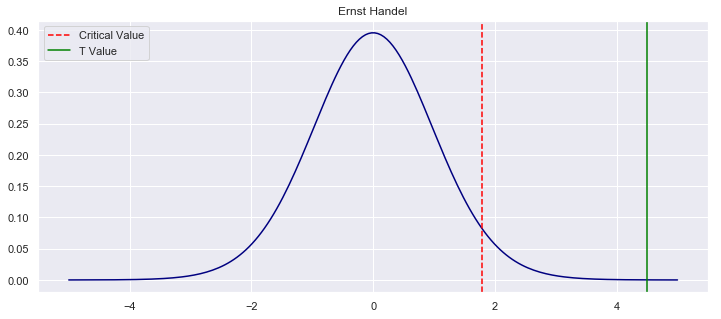

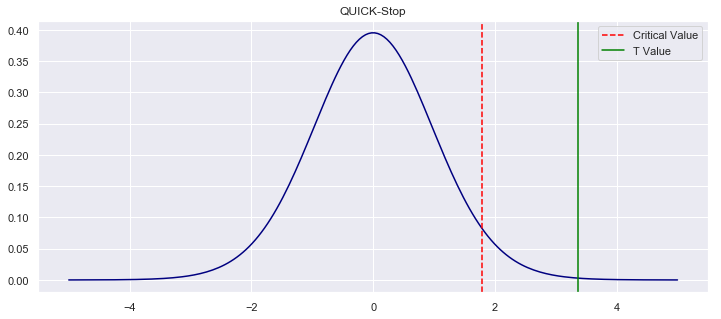

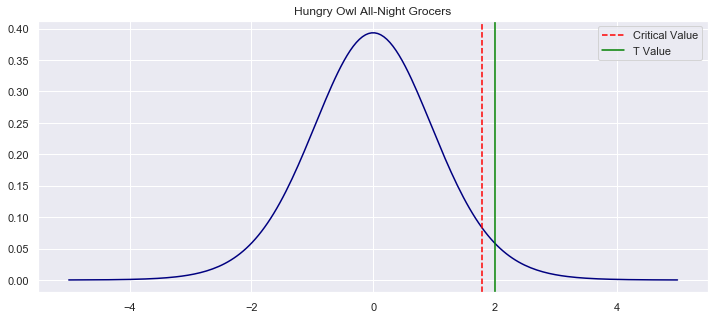

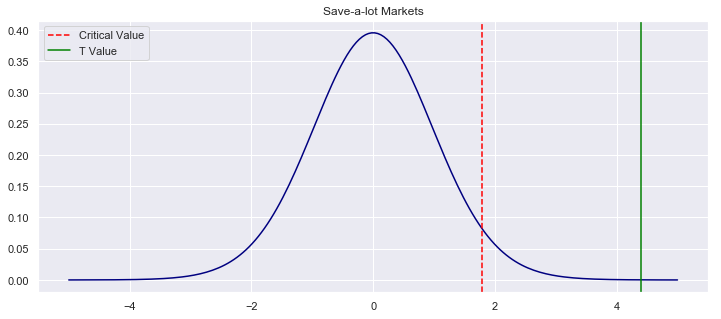

In [733]:
customer_num = 1
for customer in company_orders:
    print(customer['CompanyName'].iloc[0])
    output = stats.ttest_1samp(customer['Revenue'], super_mean)
    print(output)
    critical = stats.t.ppf(1-alpha, (len(region)-1))
    if output[0] > (critical):
        print('***Region\'s reorder level is lower than other regions***')
        if output[1] < alpha:
            print('***Statistically significant***')
        # generate points on the x axis between -5 and 5:
        xs = np.linspace(-5, 5, 200)
        # use stats.t.pdf to get values on the probability density function for the t-distribution
        # the second argument is the degrees of freedom
        ys = stats.t.pdf(xs, (len(customer)-1), 0, 1)
        # initialize a matplotlib "figure"
        fig = plt.figure(figsize=(12, 5))
        # get the current "axis" out of the figure
        ax = fig.gca()
        # plot the lines using matplotlib's plot function:
        plt.plot(xs, ys, color='navy')
        # plot a vertical line for our measured difference in rates t-statistic
        plt.axvline(critical, color='red', linestyle='--', label='Critical Value')
        plt.axvline(output[0], color='green', label='T Value')
        plt.legend()
        plt.title(customer['CompanyName'].iloc[0])
        plt.savefig("revenue_{}.png".format(customer_num))
        customer_num += 1
    print('----------------')

<a id="4.5"></a>
### 4.5 Analyze

After runnning the test on each of the 80+ customers we have, we find that four customers generate significantly high enough revenues to reject the null hypothesis, Ernst Handel (\$398,626.32), QUICK-Stop (\$393,821.00), Hungry Owl All-Night Grocers (\$136,219.55), and Save-a-lot Markets (\$431,146.19) compared to the average revenue generated of \$45,537.33. 

<a id="5"></a>
## 5. Conclusion
1. Discount Effect
We discovered that giving a discount did increase the quantity of items sold but that there was no differentiation between the levels of discounts. Our recommendations is to give discounts at the same rate but decrease the level of discount to increase profit.

2. Seasonality
Most of the variation in the dataset is within the seasons and not between them. Moving forward, our sales and cash flow projections won't have to try adjust for seasonality. 

3. Supply Region's Effect on Reorder Level
Eastern Asia has a significantly lower reorder level than other regions. No other regions had a statistically significant difference.

4. Customer's Generating the Most Revenue
After runnning the test on each of the 80+ customers we have, we find that four customers generate significantly high enough revenues to reject the null hypothesis, Ernst Handel (\$398,626.32), QUICK-Stop (\$393,821.00), Hungry Owl All-Night Grocers (\$136,219.55), and Save-a-lot Markets (\$431,146.19) compared to the average revenue generated of \$45,537.33.

<a id="6"></a>
## 6. Future Work

In future work, we'll want to look into what makes Eastern Asia so different in terms of reorder level. Are they able to deliver items faster? Do their products sell infrequently enough not to effect the bottom line? Or is there opportunity to generate more revenues if we reorder their product earlier?

We'll also want identify which customers generated the least revenue and see if we can tie any features to these two groups of customers. This will help inform us on which marketing channels are yielding the highest revenues.

<a id="7"></a>
## 7. Recap

### [0. Introduction](#0)
### [1. Discount Effect](#1)
1. [Get Data](#1.1)
2. [Explore and Clean](#1.2)
3. [Experimental Design](#1.3)
  - [Get Samples](#1.3.1)
  - [T Test](#1.3.2)
  - [Analyze Results](#1.3.3)
  - [ANOVA](#1.3.4)
4. [Conclusion](#1.4)
  
### [2. Seasonality](#2)
1. [Hypothesis](#2.1)
2. [Obtain](#2.2)
3. [Data Exploration](#2.3)
4. [Scrubbing](#2.4)
5. [Experiment](#2.5)
6. [Analyze](#2.6)

### [3. Supply Region and Reorder Rates](#3)
1. [Hypothesis](#3.1)
2. [Obtain](#3.2)
3. [Explore and Scrub](#3.3)
4. [Experiment](#3.4)
5. [Analyze](#3.5)

### [4. High Yield Customers](#4)
1. [Hypothesis](#4.1)
2. [Obtain](#4.2)
3. [Explore and Scrub](#4.3)
4. [Experiment](#4.4)
5. [Analyze](#4.5)